In [1]:
%tensorflow_version 1.x
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

import gym
import numpy as np
import random
import matplotlib.pyplot as plt
import math
from collections import deque
from keras import Sequential, models
from keras.layers import Dense
from keras.optimizers import adam
import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [0]:
class DQN():

    """ Implementation of deep q learning algorithm"""

    def __init__(self):

        """
        Initalize an Agent object
        """

        self.action_space = env.action_space.n
        self.state_space = env.observation_space.shape[0]
        self.epsilon = 1
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.95
        self.discount_factor = 0.95
        self.learning_rate = 0.001
        self.batch_size = 64
        self.memory = deque(maxlen =  10000)
        self.model = self.build_model()

    def build_model(self):

        """
        The model is based on a deep neural network. The model is trying to predict 
        the return of reward by taking an action given the state of the current environment.
        """

        model = Sequential()
        model.add(Dense(24, input_shape = (self.state_space,), activation = 'relu'))
        model.add(Dense(24, activation = 'relu'))
        model.add(Dense(self.action_space, activation = 'linear'))
        model.compile(loss = 'mse', optimizer = adam(lr = self.learning_rate))
        return model

    def save_model(self, filename = None):

        self.model.save(filename)

    def act(self, state):

        """
        To balance between exploration and exploitation, a epsilon-greedy policy is 
        introduced. It is a decaying probability, which the learning algorithm
        uses to choose between picking random action (exploration) or greedy action 
        based on existing knowledge (exploitation).
        """
        
        if random.uniform(0, 1) <= self.epsilon: # exploration
            return env.action_space.sample()
        else:
            act_values = self.model.predict(state) # exploitation
            return np.argmax(act_values[0])

    def remember(self, state, action, reward, next_state, done):

        """
        Memroy collection. Save the memory that the agent observes and we will 
        use this data later
        """ 

        self.memory.append((state, action, reward, next_state, done))

    def replay(self):
        
        """
        Agent experiences replay memory during training. Replay memory will be 
        selected randomly, so that a batch of tranining samples are decorrelted. 
        """
      
        # Wait until we have enough sample available in memeory
        if len(self.memory) < self.batch_size: 
            return

        minibatch = random.sample(self.memory, self.batch_size)
        states = np.array([i[0] for i in minibatch])
        actions = np.array([i[1] for i in minibatch])
        rewards = np.array([i[2] for i in minibatch])
        next_states = np.array([i[3] for i in minibatch])
        dones = np.array([i[4] for i in minibatch])

        # Q function is updated based on Bellman Equation
        states, next_states = np.squeeze(states), np.squeeze(next_states)
        targets = rewards + self.discount_factor * (np.amax(self.model.predict_on_batch(next_states), axis=1))*(1-dones)
        targets_full = self.model.predict_on_batch(states)
        ind = np.array([i for i in range(self.batch_size)])
        targets_full[[ind], [actions]] = targets 

        self.model.fit(states, targets_full, epochs = 1, verbose = 0)

    def total_energy(self, state):

        """
        We will use total energy to guide the agent so that even small victories could 
        have effects on learning. Total energy is the sum of its motion (i.e. kinetic energy) 
        and stored energy of position (i.e. potential energy).
        """
        
        x = state[0, 0] # position in x direction
        v = state[0, 1] # velocity

        # A change of the height is given by dh = dx cos φx, 
        # which integrates to h = 0.0025 * cos(3x)dx = 0.0025 / 3 * sin(3x) + C
        # Here we will use C = 0
        potential_energy = 0.0025 / 3 * math.sin(3 * x)
        kinetic_energy = 0.5 * (v ** 2)

        return potential_energy + kinetic_energy

    def adjust_reward(self, next_state, state):

        """
        The agent is given a reward based on how much energy it has gain afer an action.
        The reward is scaled to a range around {-1, 1}
        """

        return 1000 * (self.total_energy(next_state) - self.total_energy(state))

episode: 0/100, score: -200
episode: 1/100, score: -200
episode: 2/100, score: -200
episode: 3/100, score: -200
episode: 4/100, score: -200
episode: 5/100, score: -200
episode: 6/100, score: -200
episode: 7/100, score: -200
episode: 8/100, score: -200
episode: 9/100, score: -200
episode: 10/100, score: -200
episode: 11/100, score: -170
episode: 12/100, score: -200
episode: 13/100, score: -200
episode: 14/100, score: -200
episode: 15/100, score: -167
episode: 16/100, score: -200
episode: 17/100, score: -176
episode: 18/100, score: -195
episode: 19/100, score: -156
episode: 20/100, score: -156
episode: 21/100, score: -200
episode: 22/100, score: -188
episode: 23/100, score: -200
episode: 24/100, score: -118
episode: 25/100, score: -200
episode: 26/100, score: -159
episode: 27/100, score: -200
episode: 28/100, score: -151
episode: 29/100, score: -126
episode: 30/100, score: -150
episode: 31/100, score: -140
episode: 32/100, score: -200
episode: 33/100, score: -130
episode: 34/100, score: 

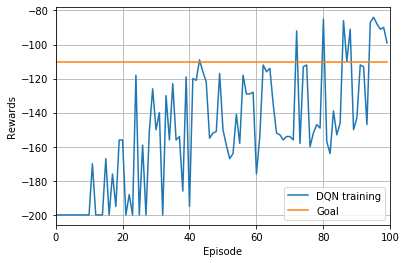

In [3]:
def train_dqn(episodes, res, x):

    """
    Train dqn model to interact with and learn from the environment
    """
    
    loss = []
    agent = DQN() 
  
    for episode in range(episodes):
        env.seed(episode)
        state = env.reset()
        state = np.reshape(state, (1, 2))
        score = 0
        max_steps = 200

        # Exploration is gradually reduced with training episodes
        agent.epsilon = max(agent.epsilon_min, agent.epsilon * agent.epsilon_decay) 

        for i in range(max_steps):
            action = agent.act(state)
            next_state, reward, done, _ = env.step(action)
            next_state = np.reshape(next_state, (1, 2))
            score = score -1
            reward = agent.adjust_reward(next_state, state)
            res.append(reward)
            x.append(next_state[0,0])
            agent.remember(state, action, reward, next_state, done)
            state = next_state
            agent.replay()

            # The episode is done when the agent reaches the goal or 200 steps
            if done: 
                print("episode: {}/{}, score: {}".format(episode, episodes, score))
                break
        env.close()
        loss.append(score)


    agent.save_model(filename = 'MountainCar-v0-dqn.h5')
    return loss, res

if __name__ == '__main__':
    env = gym.make('MountainCar-v0')
    ep = 100
    res = []
    x = []
    loss, res = train_dqn(ep, res, x)

    ### Visualize the process of training dqn model
    plt.subplots(figsize= (6, 4))
    plt.plot(list(range(len(loss))), loss, label = 'DQN training')
    plt.plot(list(range(len(loss))), np.ones((len(loss), 1))* -110, label = 'Goal')
    plt.xlabel('Episode')
    plt.ylabel('Rewards')
    plt.legend(loc = 'lower right')
    plt.xlim(0, len(loss))
    plt.grid(True)
    plt.show()

In [4]:
def test_dqn(episode):

    """
    Valide dqn model with 100 trials. MountainCarContinuous-v0 defines "solving" 
    as getting average reward of 90.0 over 100 consecutive trials.
    """
  
    episodes = episode
    scores = []

    for e in range(episodes):
        state = env.reset()
        score = 0
        while True:
            action = np.argmax(model.predict(np.array([state])))
            state, reward, done, _ = env.step(action)
            score += reward
            if done:
                scores.append(score)
                break
        env.close()
    return np.average(scores)

if __name__ == '__main__':
    env = gym.make('MountainCar-v0')
    model = models.load_model('MountainCar-v0-dqn.h5')
    ep = 100
    loss = test_dqn(ep)
    print('Average rewards in the last 100 episodes: {}'.format(loss))

Average rewards in the last 100 episodes: -105.69
